# Antarctica Sea Surface Temperature

## Creating the Model Grid

First, import packages to re-create and visualize the model grid here:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy.interpolate import griddata
import netCDF4 as nc4

## My Model

The grid for my model will be located on the coast of Antarctica covering 50-80$^{\circ}$W in longitude and 50-80$^{\circ}$S in latitude. The grid spacing will be $1/12^{\circ}$ in the zonal (east-west) direction and $1/12^{\circ}$ in the meridional (north-south) direction, covering a grid of 360 rows and 360 columns. 

In the data file for my model, I will specifiy the following parameters in the `PARM04` namelist in the `data` file:

```
usingSphericalPolarGrid=.TRUE.,
delX=360*0.0.083333,
delY=360*0.0.083333,
xgOrigin=-80,
ygOrigin=-80,
```

This grid can be recreated in Python as follows:

In [2]:
# define the parameters that will be used in the data file
delX = 1/12
delY = 1/12
xgOrigin = -80
ygOrigin = -80
n_rows = 360
n_cols = 360

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

### Visualizing the Grid
The grids above can be visualized as follows:

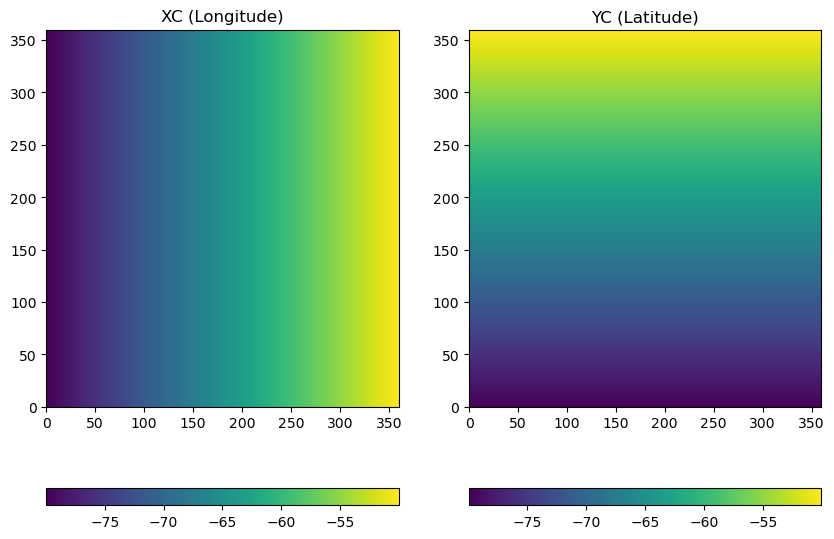

In [3]:
# make a plot of XC and YC
plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC)
plt.colorbar(C, orientation = 'horizontal')
plt.title('XC (Longitude)')

plt.subplot(1,2,2)
C = plt.pcolormesh(YC)
plt.colorbar(C, orientation = 'horizontal')
plt.title('YC (Latitude)')

plt.show()

### Visualizing the Grid on a Map with Cartopy
To get a sense of where the model is located on the globe, cartopy can be be used to plot the domain on the globe:

/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:712: RuntimeWarning: invalid value encountered in disjoint
  return lib.disjoint(a, b, **kwargs)
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:671: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.interse

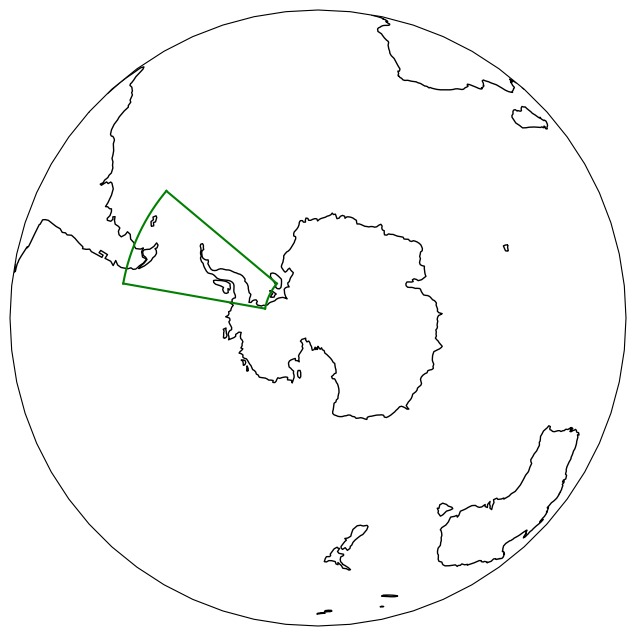

In [4]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.Orthographic(0, -90))
ax.plot(XC[:,0], YC[:,0], 'g-', transform=ccrs.PlateCarree())
ax.plot(XC[:,-1], YC[:,-1], 'g-', transform=ccrs.PlateCarree())
ax.plot(XC[0,:], YC[0,:], 'g-', transform=ccrs.PlateCarree())
ax.plot(XC[-1,:], YC[-1,:], 'g-', transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
plt.show()

### Visualizing the Grid Spacing
The model grid is defined in terms of units in longitude and latitude although it is useful to quantify the grid spacing in terms of more familiar units, such as meters. The following `great_circle_distance` function can be used to quantify this distance:

In [5]:
def great_circle_distance(lon_ref, lat_ref, Lon, Lat):
    earth_radius = 6371000
    lon_ref_radians = np.radians(lon_ref)
    lat_ref_radians = np.radians(lat_ref)
    lons_radians = np.radians(Lon)
    lats_radians = np.radians(Lat)
    lat_diff = lats_radians - lat_ref_radians
    lon_diff = lons_radians - lon_ref_radians
    d = np.sin(lat_diff * 0.5) ** 2 + np.cos(lat_ref_radians) * np.cos(lats_radians) * np.sin(lon_diff * 0.5) ** 2
    h = 2 * earth_radius * np.arcsin(np.sqrt(d))
    return(h)

Then, loop through the points to generate inter-point distances in the horizontal (`dXC`) and vertical (`dYC`) directions:

In [6]:
dXC = np.zeros((np.shape(XC)[0], np.shape(XC)[1]-1))
for row in range(np.shape(XC)[0]):
    for col in range(np.shape(XC)[1]-1):
        dXC[row,col] = great_circle_distance(XC[row,col], YC[row,col], XC[row,col+1], YC[row,col+1])

dYC = np.zeros((np.shape(YC)[0]-1, np.shape(YC)[1]))
for row in range(np.shape(XC)[0]-1):
    for col in range(np.shape(XC)[1]):
        dYC[row,col] = great_circle_distance(XC[row,col], YC[row,col], XC[row+1,col], YC[row+1,col])

Finally, make a plot of the inter-point distances:

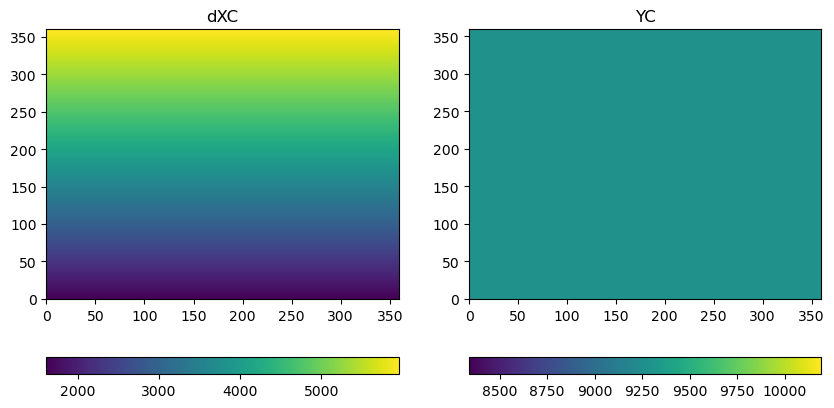

In [7]:
# make a plot of XC and YC
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(dXC)
plt.colorbar(C, orientation = 'horizontal')
plt.title('dXC')

plt.subplot(1,2,2)
C = plt.pcolormesh(dYC.round(3))
plt.colorbar(C, orientation = 'horizontal')
plt.title('YC')

plt.show()

As we can see the grid has a resolution of about 7 km, although there is a north-south gradient in horizontal distances (in other words, points further north are closer together). 